In [1]:
import sys
import os
# Append the library path to PYTHONPATH, so library can be imported.
sys.path.append(os.path.dirname(os.getcwd()))
import shutil

import numpy as np
import pandas as pd

from library import network as nw
from library import common as cm

Using TensorFlow backend.


In [2]:
%run setup.py

np.random.seed(RANDOM_SEED)

In [3]:
%run Load_Clean_aux.py
max_period = max([int(s[6:]) for s in df.columns if 'period' in s])

C:\Users\Weiguan\Anaconda3\envs\tfenv\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


We remove samples within one hedging offset before OPTION expiry. 117906 samples (3.11%) are removed. We have 96.89% of original data left, yielding a size of 3679176.
We remove samples when the next trade is not available. 1732829 samples (47.10%) are removed. We have 51.26% of original data left, yielding a size of 1946347.
We remove samples when the matching tol is larger than 0.1H. 1049806 samples (53.94%) are removed. We have 23.61% of original data left, yielding a size of 896541.
We remove NA implvol0. 0 samples (0.00%) are removed. We have 23.61% of original data left, yielding a size of 896541.
We remove unreasonable implvol0. 4 samples (0.00%) are removed. We have 23.61% of original data left, yielding a size of 896537.
We remove the first and the last trading period of each day. 233242 samples (26.02%) are removed. We have 17.47% of original data left, yielding a size of 663295.
We remove samples within one hedging offset before FUTURES expiry. 7987 samples (1.20%) are remov

#### Choose features and hypers

In [4]:
hypers = {
    'nodes_per_layer': (30, 30),
    'reg_alpha': 1e-2,
    'lr': 1e-4,
    'epochs': 300,
    'outact': 'linear'
}

In [5]:
if FEATURE_SET == 'normal_feature':
    ori_fea = ['M0', 'tau0_implvol0']
    sub_res = res_dir + f"Network/Normal_Feature/"

if FEATURE_SET == 'delta_vega':
    ori_fea = ['delta_bs', '1_over_sqrt_tau', 'vega_n']
    sub_res = res_dir + f"Network/Delta_Vega/"
    
if VIX:
    ori_fea += ['fake_vix']

use_fea = [x + '_t' for x in ori_fea] + ['cp_int']

if AGG_SIDE_FLAG:
    use_fea += ['AggressorSide']

os.makedirs(sub_res, exist_ok=True)
# Copy data setup file from the clean data folder, and then append network setup.
shutil.copy('setup.py', sub_res)
print(f'Result is stored at:\n{res_dir}')

Result is stored at:
C:\Users\Weiguan\Dropbox\Research\DeepHedging\Debug_0404\Euroxx\Result/FREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5_MINTAU=0_Permute=False_VIX=False_WINDOW=90D_AGGSIDE=False_MATCHING=0.1H_CLOSENESS=False/


#### Step 4: Train a network with given hypers



 Working on period 0.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 300316 samples, validate on 41169 samples
Epoch 1/1
300316/300316 [==============================] - 7s 23us/step - loss: 0.2647 - mean_squared_error: 0.0689 - val_loss: 0.0877 - val_mean_squared_error: 0.0038


 Working on period 1.

Train on 232771 samples, validate on 61726 samples
Epoch 1/1
232771/232771 [==============================] - 5s 23us/step - loss: 0.2860 - mean_squared_error: 0.0577 - val_loss: 0.1346 - val_mean_squared_error: 0.0155


 Working on period 2.

Train on 218237 samples, validate on 47926 samples
Epoch 1/1
218237/218237 [==============================] - 5s 24us/step - loss: 0.2912 - mean_squared_error: 0.0629 - val_loss: 0.1211 - val_mean_squared_error: 0.0067


 Working on period 3.

Train on 219452 samples, validate on 55766 samples
Epoch 1/1
219452/219452 [==============================] - 5s 21us/step 

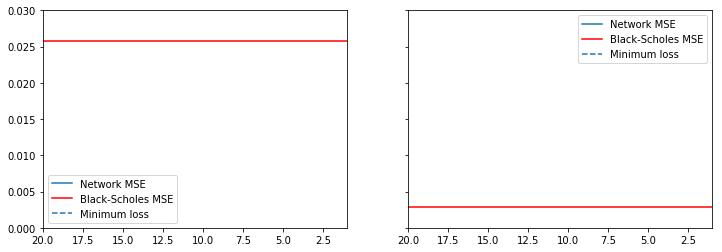

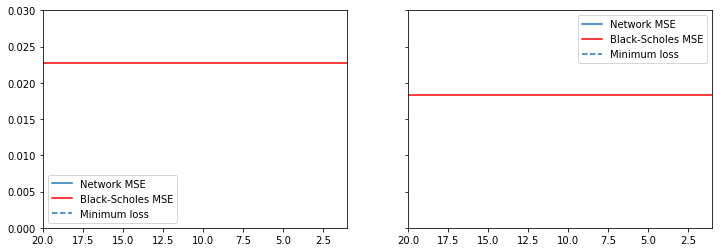

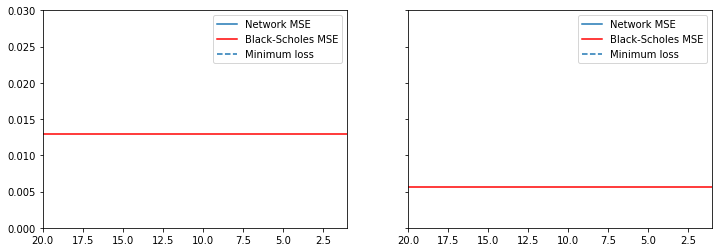

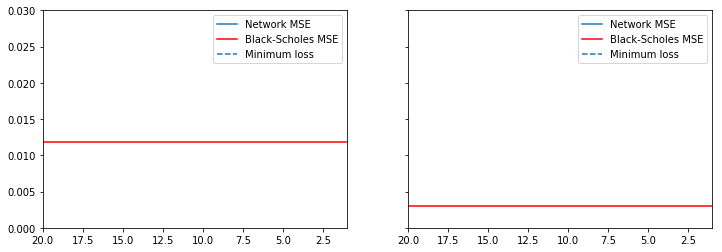

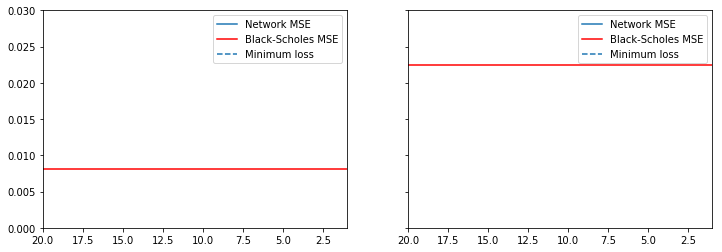

In [6]:
if not PERMUTE:
    """
    Here, we use a bit different structure as the simulation data.
    In case of no permutation, there are only one ckp, history, plot folder.
    In case of permuation, in each of ckp, history and plot folders, we have many permutation folders.

    As for the pnl folder:
    In case of no permutation, only one pnl file.
    in case of permutations, many pnl files.
    This is consistent as the regression folder.
    """
    sub_res_dir = {
        'ckp': sub_res + 'ckp/',
        'history': sub_res + 'history/',
        'pnl': sub_res + 'pnl/',
        'plot': sub_res + 'plot/'}
    
    for key, value in sub_res_dir.items():
        os.makedirs(value, exist_ok=True)
        
    df = nw.rolling_net(
        df,
        ori_fea=ori_fea,
        use_fea=use_fea,
        end_period=max_period,
        hypers=hypers,
        sub_res_dir=sub_res_dir)
    
    cm.store_pnl(df, df['delta_nn'], sub_res_dir['pnl'] + 'pnl.csv')

In [7]:
if PERMUTE:
    for p in range(NUM_PERMUTE):
        """
        We keep all the pnl in the same folder, because each
        permute only has one pnl files and we can use the same code 
        for evaluation. But ckp, history, and plots are in 
        different permutations sub folders respectively.
        """
        sub_res_dir = {
            'ckp': sub_res + f'ckp/permute{p}/',
            'history': sub_res + f'history/permute{p}/',
            'pnl': sub_res + f'pnl/',
            'plot': sub_res + f'plot/permute{p}/'
        }
        
        for key, value in sub_res_dir.items():
            os.makedirs(value, exist_ok=True)
        
        df_permute = df.copy()
        df_permute = cm.rolling_permute(df_permute, random_seed=i+100)

        df_permute = nw.rolling_permute(
            df_permute, 
            ori_fea=ori_fea, 
            use_fea=use_fea, 
            hypers=hypers, 
            sub_res_dir=sub_res_dir)
        
        cm.store_pnl(df_permute, df_permute['delta_nn'], sub_res_dir['pnl'] + f'pnl{p}.csv')

In [8]:
with open(f'{sub_res}additional_paras.txt', 'a') as file:
    file.write('\n\nThe following is network setup.\n')
    file.write(f'Date and time = {datetime.datetime.now()}\n')
    for n, x in [
        ('Learning rate', hypers['lr']),
        ('L2 regularization alpha', hypers['reg_alpha']),
        ('Output node activation', hypers['outact']),
        ('Nodes per layer', hypers['nodes_per_layer']),
        ('Number of training epochs', hypers['epochs'])
    ]:
        file.write(f'{n} = {x}\n')